In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Model
from keras.layers import Dense, Dropout, Input
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import sys 
from numpy import trapz

%matplotlib inline

In [2]:
# Get the required files
df_sig = pd.read_hdf('mc16ae_Honly_sig_NN_var.h5', 'df_sig')
df_bkg2 = pd.read_hdf('mc16a_qZZ_bkg_NN_var.h5','df_bkg2')
#get 1 jet events
df_sig1j = df_sig[df_sig['n_jets']==1]
df_bkg21j = df_bkg2[df_bkg2['n_jets']==1]

In [41]:
#define the discriminant
df_sig['ME_disc_0j'] = np.log10(df_sig['ggHZZ_ME_0j']/(df_sig['ggZZ_ME_0j']+0.1*df_sig['qqZZ_ME_0j']))
df_bkg2['ME_disc_0j'] = np.log10(df_bkg2['ggHZZ_ME_0j']/(df_bkg2['ggZZ_ME_0j']+0.1*df_bkg2['qqZZ_ME_0j']))

In [3]:
# names of event-level branches
npart = ["ggZZ_ME_0j","ggHZZ_ME_0j","qqZZ_ME_0j","m4l_unconstrained","cos_theta_str","cos_theta_1","pt4l_fsr","phi","phi_1","Z1_m","Z2_m","n_jets"]

In [4]:
df= pd.concat((df_sig[npart], df_bkg2[npart]), ignore_index=True)
#df.head()
X = df.as_matrix()
w =  pd.concat((df_sig['weight'], df_bkg2['weight']), ignore_index=True).values
y = []
for _df, ID in [(df_sig, 0), (df_bkg2, 1)]:
    y.extend([ID] * _df.shape[0])
y = np.array(y)

/opt/rh/rh-python36/root/usr/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


In [5]:
ix = range(X.shape[0])
X_train, X_test, y_train, y_test, w_train, w_test, ix_train, ix_test = train_test_split(X, y, w, ix, train_size=0.5)

/opt/rh/rh-python36/root/usr/lib64/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [22]:
inputs = Input(shape=(X_train.shape[1], )) # placeholder

hidden = Dense(2, activation='relu')(inputs)
#hidden = Dropout(0.2)(hidden)
hidden = Dense(20, activation='relu')(hidden)
#hidden = Dropout(0.2)(hidden)
#hidden = Dense(30, activation='relu')(hidden)
#hidden = Dropout(0.2)(hidden)
outputs = Dense(2, activation='sigmoid')(hidden)
# last layer has to have the same dimensionality as the number of classes we want to predict, here 3

model = Model(inputs, outputs)
model.summary()
plot_model(model, 'temp.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 12)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 26        
_________________________________________________________________
dense_4 (Dense)              (None, 20)                60        
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 42        
Total params: 128
Trainable params: 128
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile('adam', 'sparse_categorical_crossentropy')

In [24]:
from collections import Counter
Counter(y_test)

Counter({1: 21425, 0: 14584})

In [34]:
print ('Training:')
try:
    model.fit(
        X_train, y_train, 
        #class_weight={ # rebalance class representation
         #   0 : 0.40 * (float(len(y)) / (y == 0).sum()),
          #  1 : 0.60 * (float(len(y)) / (y == 1).sum()), },
        callbacks = [
            EarlyStopping(verbose=True, patience=20, monitor='val_loss'),
            ModelCheckpoint('./tutorial-progress.h5', monitor='val_loss', verbose=True, save_best_only=True)
        ],
        epochs=10000, 
        validation_split = 0.4,
        verbose=False)
except KeyboardInterrupt:
    print('Training ended early.')

Training:

Epoch 00001: val_loss improved from inf to 0.43037, saving model to ./tutorial-progress.h5

Epoch 00002: val_loss improved from 0.43037 to 0.43008, saving model to ./tutorial-progress.h5

Epoch 00003: val_loss did not improve from 0.43008

Epoch 00004: val_loss did not improve from 0.43008

Epoch 00005: val_loss did not improve from 0.43008

Epoch 00006: val_loss did not improve from 0.43008

Epoch 00007: val_loss did not improve from 0.43008

Epoch 00008: val_loss did not improve from 0.43008

Epoch 00009: val_loss improved from 0.43008 to 0.42950, saving model to ./tutorial-progress.h5

Epoch 00010: val_loss did not improve from 0.42950

Epoch 00011: val_loss did not improve from 0.42950

Epoch 00012: val_loss did not improve from 0.42950

Epoch 00013: val_loss did not improve from 0.42950

Epoch 00014: val_loss did not improve from 0.42950

Epoch 00015: val_loss did not improve from 0.42950

Epoch 00016: val_loss did not improve from 0.42950

Epoch 00017: val_loss did not

In [35]:
# -- load in best network
model.load_weights('./tutorial-progress.h5')
# -- Save network weights and structure
print( 'Saving model...')
model.save_weights('./tutorial.h5', overwrite=True)
json_string = model.to_json()
open('./tutorial.json', 'w').write(json_string)
print ('Done')

Saving model...
Done


In [36]:
print ('Testing...')
yhat = model.predict(X_test, verbose = True, batch_size = 400)

Testing...
36009/36009 [==============================] - 0s 2us/step


In [37]:
len(yhat)

36009

In [38]:
a = np.linspace(0,1,100)
#print(a)
sig_eff = []
b_rej = []
yhat_cls_1=[]
for j in a:
    for i in range(0, 36009):
        
        if yhat[i][0]>j:
            yhat_cls_1.append(0)
        else:
            yhat_cls_1.append(1)
    yhat_cls = np.array(yhat_cls_1)
    yhat_cls_1.clear()
    #print(w_test[(y_test == 0) & (yhat_cls == 0)].sum() / w_test[y_test == 0].sum())
    #print(1- w_test[(y_test == 1) & (yhat_cls == 0)].sum() / w_test[y_test == 1].sum())
    sig_eff.append(w_test[(y_test == 0) & (yhat_cls == 0)].sum() / w_test[y_test == 0].sum())
    # bkg eff = weighted fpr --> out of all bkg events, what % do we classify as signal?
    b_rej.append(1 - w_test[(y_test == 1) & (yhat_cls == 0)].sum() / w_test[y_test == 1].sum())

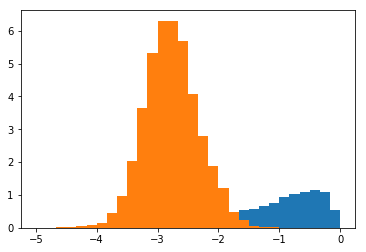

In [39]:
df_sig['ME_disc_0j'] = np.log10(df_sig['ggHZZ_ME_0j']/(df_sig['ggZZ_ME_0j']+0.1*df_sig['qqZZ_ME_0j']))
df_bkg2['ME_disc_0j'] = np.log10(df_bkg2['ggHZZ_ME_0j']/(df_bkg2['ggZZ_ME_0j']+0.1*df_bkg2['qqZZ_ME_0j']))
(n_sig, bins_sig, patches_sig) = plt.hist(df_sig['ME_disc_0j'],range=(-5, 0), bins=30, label='hst', weights=df_sig['weight'])
(n_bkg, bins_bkg, patches_bkg) = plt.hist(df_bkg2['ME_disc_0j'], range=(-5, 0), bins=30, label='hst', weights=df_bkg2['weight'])
a = np.linspace(-5, 0, 30)
sig_eff_old = []
bkg_rej_old = []
total_sig=0
total_bkg=0
for sig in n_sig:
    total_sig = total_sig+sig
for bkg in n_bkg:
    total_bkg = total_bkg+bkg

for j in a:
    TP=0
    FP =0
    for i in range(0, 30):
        if bins_sig[i]>j:
            TP=TP+n_sig[i]
            FP=FP+n_bkg[i]
    sig_eff_old.append(TP/total_sig)
    bkg_rej_old.append(1-(FP/total_bkg))
    

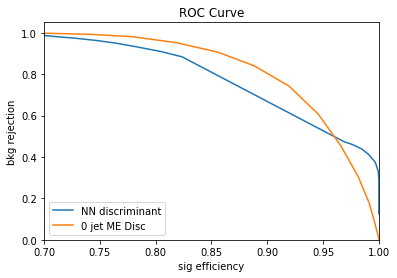

In [40]:
plt.figure()
plt.title('ROC Curve')
plt.plot(sig_eff, b_rej,  label = 'NN discriminant')
plt.plot(sig_eff_old, bkg_rej_old, label ='0 jet ME Disc')
plt.legend(loc = 'lower left')

plt.xlim([0.7, 1])
plt.ylim([0, 1.05])
plt.ylabel('bkg rejection')
plt.xlabel('sig efficiency')
plt.show()